### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{0}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

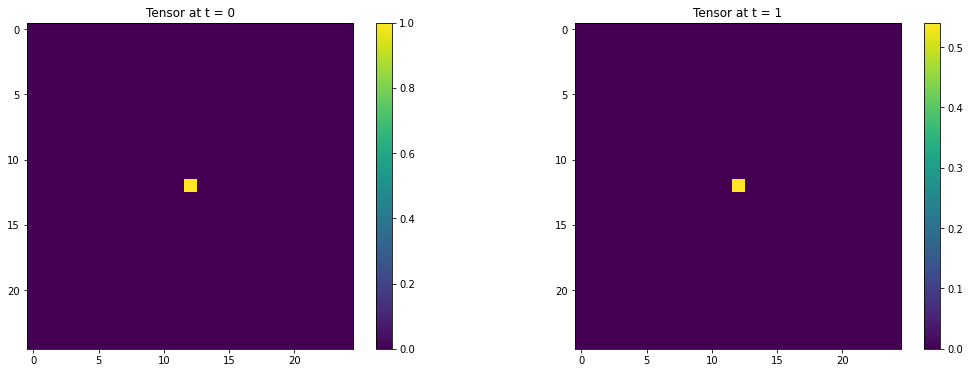

In [6]:
# Specify the size of the tensor
xysize = 25

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

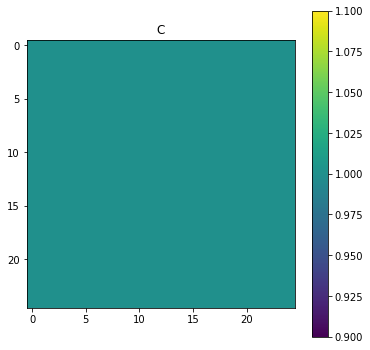

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [7]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float().requires_grad_()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

# c = c.to(device)
print(c)

#### Sigma2

In [8]:
l = xysize/10

In [9]:
value_origin_point = - 9 * (4-0)
k = 400

In [10]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [11]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

0.125


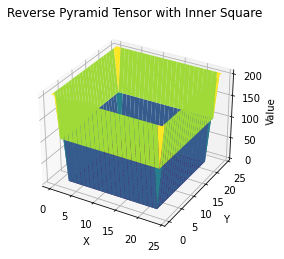

In [12]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

# sigma2 = torch.from_numpy(sigma2).to(device)

[[204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8
  204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8 204.8
  204.8]
 [204.8 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4
  102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4 102.4
  204.8]
 [204.8 102.4   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  102.4
  204.8]
 [204.8 102.4   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  102.4
  204.8]
 [204.8 102.4   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  102.4
  204.8]
 [204.8 102.4   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  102.4
  204.8]
 [204.8 102.4   0.    0.    0.    0.    0.    0.    0.    0.  

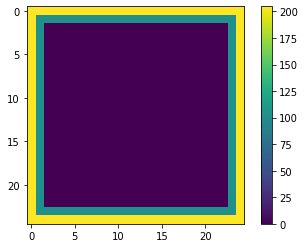

In [13]:
print(sigma2)
plt.imshow(sigma2, cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [14]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

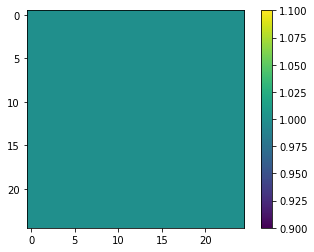

In [15]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### one time step - skipping layers

In [16]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
#         output_list = [status_tn]

#         c = torch.ones((self.xysize, self.xysize), device=device)
        
#         for i in range(c_value.shape[0]):
#             for j in range(c_value.shape[0]):
#                 ones = torch.zeros((self.xysize, self.xysize), device=device)
#                 ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0]), j*int(self.xysize/c_value.shape[0]):(j+1)*int(self.xysize/c_value.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#                 c += ones * c_value[i]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

In [17]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
#         output_list = [status_tn]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
#         # status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (1 * 1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

##### direchlet boundary condition

In [18]:
# direchlet boundary condition
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xsize, ysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        # self.xysize = xysize
        self.xsize = xsize
        self.ysize = ysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        output_list = [status_tn]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xsize, self.ysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xsize, self.ysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        # status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (1 * 1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

In [19]:
# direchlet boundary condition
class AI4WaveNeuralNetwork_One_Skipping_New(nn.Module):
    def __init__(self, xsize, ysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping_New, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        # self.xysize = xysize
        self.xsize = xsize
        self.ysize = ysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        c_output = c.unsqueeze(0).unsqueeze(0)
        output_list = [c_output, status_tn_1, status_tn]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xsize, self.ysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xsize, self.ysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        # status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (1 * 1) / 2
        
        output_list.append(status_tn1)

        # print(c.shape)
        # print(status_tn_1.shape)
        # print(status_tn.shape)
        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

##### Neumann boundary condition

In [20]:
# Neumann boundary condition

import torch
import torch.nn as nn
import torch.nn.functional as F

class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xsize, ysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        self.padding = (kernel_size - 1) // 2  # Calculate padding size

        # Create a Conv2d layer with the specified weight, input size, and NO padding here
        # Padding will be applied manually in the forward method
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=0, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xsize = xsize
        self.ysize = ysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        output_list = [status_tn]

        # Manually pad the input with 'replicate' to simulate Neumann boundary conditions
        padded_status_tn = F.pad(status_tn.view(1, 1, self.xsize, self.ysize), (self.padding, self.padding, self.padding, self.padding), 'replicate')
        padded_c_status_tn = F.pad((c * status_tn).view(1, 1, self.xsize, self.ysize), (self.padding, self.padding, self.padding, self.padding), 'replicate')
        padded_c = F.pad(c.view(1, 1, self.xsize, self.ysize), (self.padding, self.padding, self.padding, self.padding), 'replicate')

        # Apply convolution to the padded inputs
        conv_term = self.conv_layer(padded_c_status_tn) + c * self.conv_layer(padded_status_tn) - status_tn * self.conv_layer(padded_c)
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term.view(self.xsize, self.ysize)) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [21]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [22]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

### Define functions to form C values

#### Real Data

In [23]:
# Path to the .npy file
file_path = "/home/dg321/gitTest/PRI/irp/AI4Multiphase/Data_Haifa/velocity.npy"

# Load the data
data = np.load(file_path)

print(data.shape)

(3001, 2194)


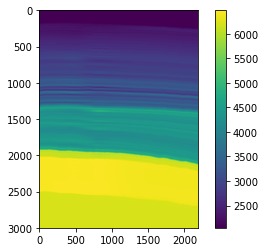

In [24]:
plt.imshow(data)
plt.colorbar()

In [25]:
# xysize = 2000
xsize = 100   # 3000
ysize = 100   # 2000

In [26]:
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

# Resize the data
resized_data = resize(data, (xsize, ysize))

# Scale the values between 5 and 15
scaler = MinMaxScaler(feature_range=(15, 25))
scaled_data = scaler.fit_transform(resized_data.reshape(-1, 1))

# Reshape the data back to the original shape
scaled_data = scaled_data.reshape(xsize, ysize)

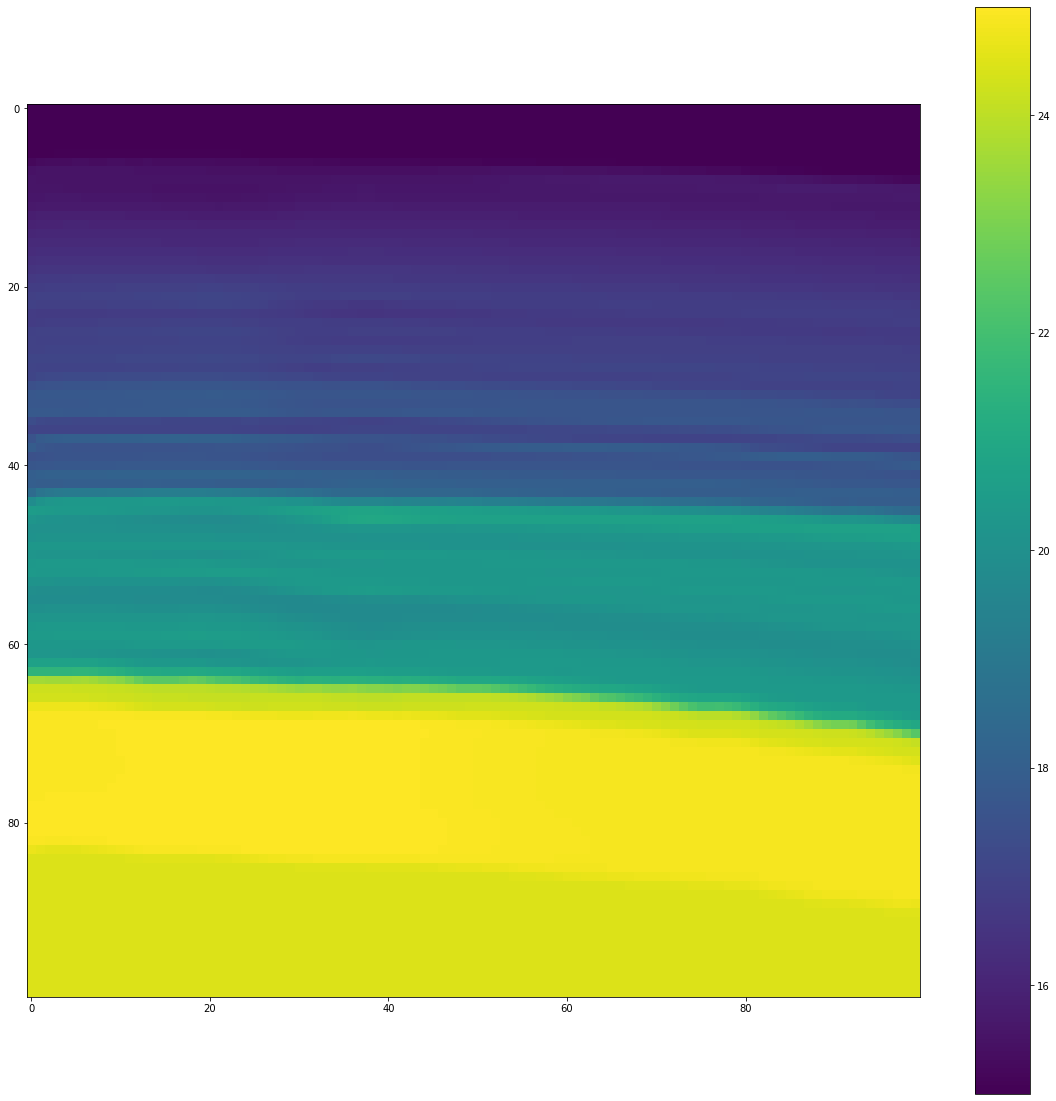

In [27]:
plt.figure(figsize=(20, 20))
plt.imshow(scaled_data)
plt.colorbar()

In [28]:
def create_c_field(requires_grad):
    c = torch.tensor(scaled_data, device=device, dtype=torch.float32, requires_grad=requires_grad)
    return c

In [29]:
def create_c_field_likereal(initial_value, requires_grad):
    scaled_data_tensor = torch.tensor(scaled_data, device=device, dtype=torch.float32)
    c = initial_value * torch.ones_like(scaled_data_tensor, device=device, dtype=torch.float32, requires_grad=requires_grad)
    return c

### Data assimilation one timestep - skipping layers

#### Generate Obs

##### create initial step

In [30]:
# # Define the number of source points along each dimension
# y_points = 1  # y direction
# x_points = 1   # x direction

# # Define the x and y coordinates
# x_coords = torch.linspace(0, 1, x_points+2)
# y_coords = torch.linspace(0, 1, y_points+2)

# # x_coords = x_coords[1:-1]
# # y_coords = y_coords[1:-1]


# # Create a grid of points
# x_grid, y_grid = torch.meshgrid(x_coords, y_coords)

# # Flatten the grids and pair up the coordinates
# source_locations = list(zip(x_grid.flatten(), y_grid.flatten()))


# Define the number of source points along each dimension
y_points = 1-2 # 3  # y direction
x_points = 1-2 # 3   # x direction

# Define the x and y coordinates
# x_coords = torch.linspace(0, 1, x_points+2)
# y_coords = torch.linspace(0, 1, y_points+2)

x_coords = torch.linspace(0.5, 0.5, x_points+2)
y_coords = torch.linspace(0.0, 0.0, y_points+2)

# x_coords = torch.tensor([0.1000])
# y_coords = torch.tensor([0.9000])
x_coord = [50]
y_coord = [50]
x_coords = torch.tensor([y / xsize for y in y_coord])
y_coords = torch.tensor([x / ysize for x in x_coord])

print(x_coords)

# x_coords = x_coords[1:-1]
# y_coords = y_coords[1:-1]


# Create a grid of points
x_grid, y_grid = torch.meshgrid(x_coords, y_coords)

# Flatten the grids and pair up the coordinates
source_locations = list(zip(x_grid.flatten(), y_grid.flatten()))

tensor([0.5000])


/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [31]:
print(x_coords)

tensor([0.5000])


In [32]:
# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y, peak_value=1.0):
    # assert len(mu_x) == len(mu_y), "mu_x and mu_y must have the same length"
    result = torch.zeros_like(x)
    for mx, my in zip(mu_x, mu_y):
        exponent = -((x - mx)**2 / (2 * sigma_x**2) + (y - my)**2 / (2 * sigma_y**2))
        gauss = torch.exp(exponent)
        result += gauss / gauss.max()
    return result * peak_value

# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y, peak_value=1.0):
    
#     # Convert mu_x and mu_y to tensors
#     mu_x = mu_x.detach().reshape(-1, 1, 1)
#     mu_y = mu_y.detach().reshape(-1, 1, 1)

#     print('1')

#     # Compute the exponent in a vectorized manner
#     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))

#     print('2')

#     # Compute gauss in a vectorized manner
#     gauss = torch.exp(exponent)

#     print('3')

#     # Normalize gauss along the 0th dimension
#     gauss = gauss / gauss.max(dim=0)[0]

#     print('4')

#     # Sum gauss along the 0th dimension
#     result = gauss.sum(dim=0)

#     print('5')

#     return result * peak_value



# # Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y, peak_value=1.0):
#     x = x.unsqueeze(-1)
#     y = y.unsqueeze(-1)
#     mu_x = mu_x.unsqueeze(0).unsqueeze(0)
#     mu_y = mu_y.unsqueeze(0).unsqueeze(0)
#     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
#     gauss = torch.exp(exponent)
#     result = (gauss / gauss.max(dim=(0, 1), keepdim=True)).sum(dim=-1)
#     return result * peak_value

# Create a meshgrid
x_values = np.linspace(0, 1, ysize)
y_values = np.linspace(0, 1, xsize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

peak_value=1.0

# Define the mu_x and mu_y values for the five points
# mu_x = [0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90]
# mu_y = [0.95, 0.95, 0.95, 0.95, 0.95, 0.80, 0.80, 0.80, 0.80, 0.80, 0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5, 0.5, 0.15, 0.15, 0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]

# Define the mu_x and mu_y values for the five points
# mu_x = torch.tensor([0.05, 0.10, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.90, 0.95] * 13)  # Repeat the list 7 times
# mu_y = torch.tensor([0.95, 0.80, 0.65, 0.35, 0.5, 0.4, 0.3, 0.2, 0.15, 0.10, 0.05, 0.01, 0]).repeat_interleave(10)  # Repeat each element 5 times

# Extract the x and y coordinates from the source locations
mu_x, mu_y = zip(*source_locations)
# Convert the lists to PyTorch tensors
mu_x = torch.tensor(mu_x, dtype=torch.float32)
mu_y = torch.tensor(mu_y, dtype=torch.float32)

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y, peak_value)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y, peak_value) * torch.cos(time_tensor_t1)

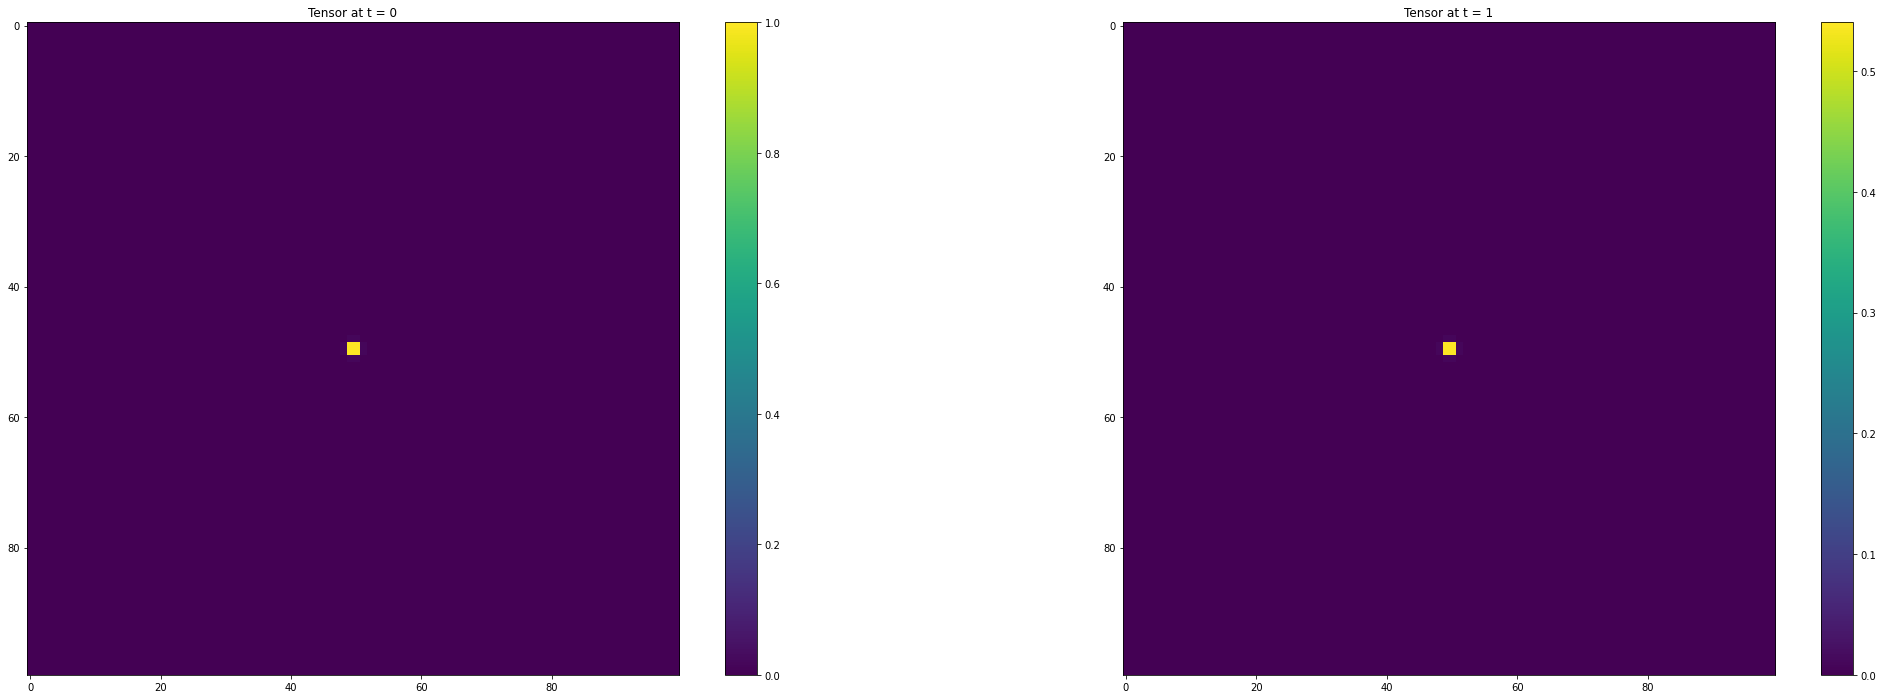

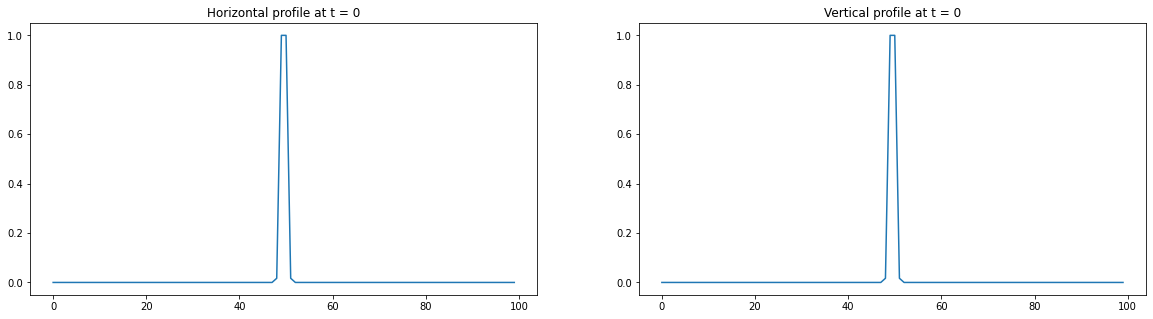

In [33]:
# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18*2, 6*2))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()


plt.figure(figsize=(20, 5))  # Increase figure size to accommodate two plots

# Calculate the horizontal profile
horizontal_profile = status_t0.cpu().detach().numpy()[xsize//2, :]  # Take the middle row

# Plot the horizontal profile
plt.subplot(1, 2, 1)  # Create the first subplot
plt.plot(horizontal_profile)
plt.title(f"Horizontal profile at t = {0}")

# Calculate the vertical profile
vertical_profile = status_t0.cpu().detach().numpy()[:, ysize//2]  # Take the middle column

# Plot the vertical profile
plt.subplot(1, 2, 2)  # Create the second subplot
plt.plot(vertical_profile)
plt.title(f"Vertical profile at t = {0}")

# Show the plot
plt.show()

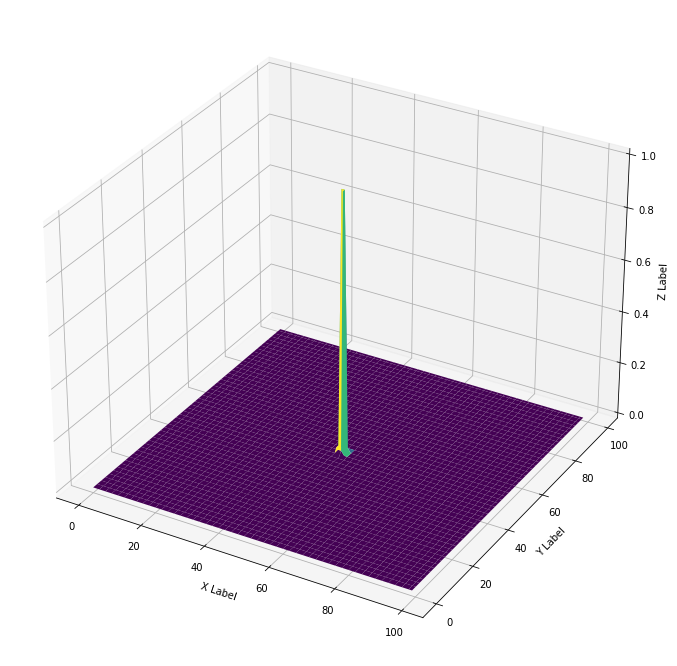

In [34]:
fig = plt.figure(figsize=(18*2, 6*2))
ax = fig.add_subplot(111, projection='3d')

# Create a grid of x, y values
x = np.arange(status_t0.numpy().shape[1])
y = np.arange(status_t0.numpy().shape[0])
x, y = np.meshgrid(x, y)

# Use status_t0.numpy() as the height values
z = status_t0.numpy()

ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

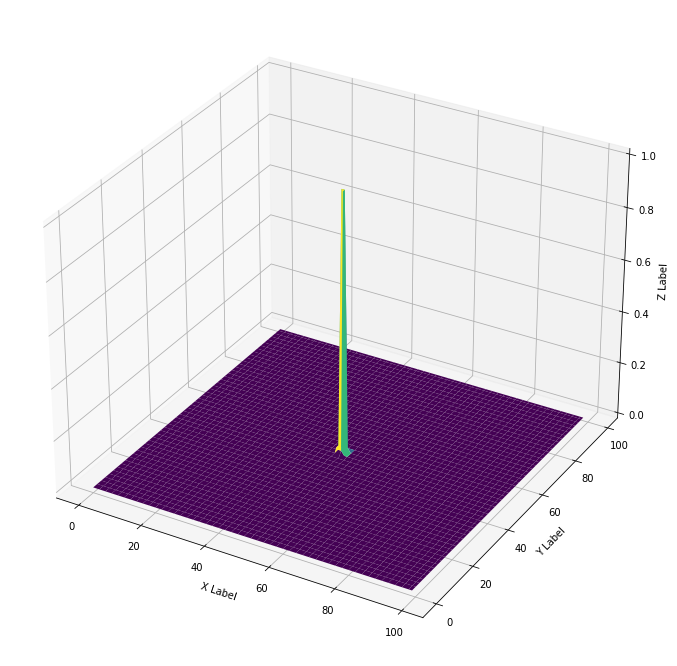

In [35]:
fig = plt.figure(figsize=(18*2, 6*2))
ax = fig.add_subplot(111, projection='3d')

# Create a grid of x, y values
x = np.arange(status_t0.numpy().shape[1])
y = np.arange(status_t0.numpy().shape[0])
x, y = np.meshgrid(x, y)

# Use status_t0.numpy() as the height values
z = status_t0.numpy()

ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

torch.Size([12, 100, 100])


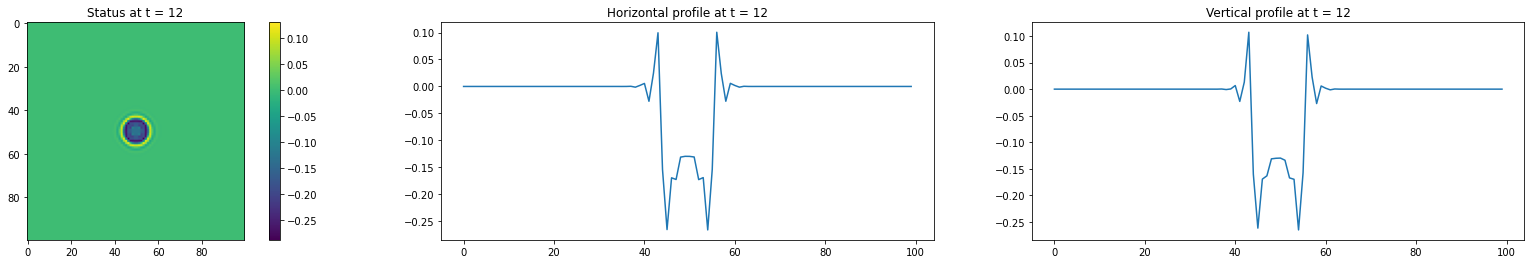

torch.Size([12, 100, 100])


In [36]:
# timesteps = 10

# # Specify the size of the tensor
# mu_x = 0.5   # 0.5
# mu_y = 0.5  # 0.5

# # # C values
# # C_tensors_list = [10, 6, 7, 8, 9]
# # # C_tensors_list = [1, 1, 1, 1, 1]
# # c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)

# # nlayers = c_tensor.size(0)

# # # Plot C
# # c = torch.ones((xysize, xysize), device=device, dtype=torch.float32)

# # for i in range(nlayers):
# #     for j in range(nlayers):
# #         ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
# #         ones[i*int(xysize/c_tensor.shape[0]):(i+1)*int(xysize/c_tensor.shape[0]), j*int(xysize/c_tensor.shape[0]):(j+1)*int(xysize/c_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
# #         c += ones * c_tensor[i]  # Use both i and j to index c_tensor

# # plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# # plt.colorbar()
# # plt.title('C Values - Ground Truth')
# # plt.show()

# # Create a meshgrid
# x_values = np.linspace(0, 1, ysize)
# y_values = np.linspace(0, 1, xsize)
# x, y = np.meshgrid(x_values, y_values)

# # Convert NumPy arrays to PyTorch tensors with float type
# x_tensor = torch.tensor(x, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.float32)

# # Equation parameters
# sqrt2 = np.sqrt(2)
# pi = np.pi

# # Define the time tensors for t = 0, 1, and 2
# time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
# time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# # Function to create 2D Gaussian distribution
# # def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
# #     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
# #     return torch.exp(exponent)

# # Parameters for Gaussian distributions
# sigma_x = 0.005
# sigma_y = 0.005

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# # t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# # t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)
# # t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# # t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# # Stack the tensors along a new dimension to create 3D tensors
# status_t0 = t0_values
# status_t1 = t1_values

# status_t0_tensor = status_t0.view(1, 1, xsize, ysize).to(device)

# status_t1_tensor = status_t1.view(1, 1, xsize, ysize).to(device)

# filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# # Define a single model
# mymodel_obs = AI4WaveNeuralNetwork_One_Skipping_New(xsize, ysize, filter_weight).to(device)


# # Forward pass through the model
# output_list = [status_t0_tensor, status_t1_tensor]
# input1 = status_t1_tensor
# input2 = status_t0_tensor


# number_rows = 5
# number_cols = 5
# number_all = number_rows * number_cols
# torch.manual_seed(0)

# # c_values_tensor_obs = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)
# # c = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)

# c = create_c_field(requires_grad=False)
# # c = create_c_field_likereal(1, requires_grad=False)

# c_show = c
# plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# # with torch.no_grad():
# #     for t in range(timesteps):
# #         output = mymodel_obs(input1, input2, c, sigma2)
# #         output_list.append(output[:,1:, :, :])
# #         input1 = output[:,1:, :, :]
# #         input2 = output[:,0:1, :, :]
# #         # if t % 10 == 0:
# #         #     output_list.append(output[:,1:, :, :])

# #     # Concatenate the output list along the time dimension
# #     output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)
# # output_tensor_obs = output[:,1:, :, :][0]

# # print(input1.shape)
# # print(input2.shape)

# for _ in range(timesteps):
#     output = mymodel_obs(input1, input2, c, sigma2)
#     # print(output.shape)
#     output_list.append(output[:,-1:, :, :])
#     input1 = output[:,-1:, :, :]
#     input2 = output[:,-2:-1, :, :]

# # Concatenate the output list along the time dimension
# output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)





# Assuming device is defined somewhere in the code
device = 'cuda'  # or 'cpu'

timesteps = 10

# Create a meshgrid
x_values = np.linspace(0, 1, ysize)
y_values = np.linspace(0, 1, xsize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type, no need for gradients
x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False)

# Define the time tensors for t = 0, 1, and 2, no need for gradients
time_tensor_t0 = torch.tensor(0, dtype=torch.float32, requires_grad=False)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32, requires_grad=False)

# Assuming gaussian2d function is defined somewhere
# Evaluate the Gaussian distributions at t = 0, 1, and 2 without tracking gradients
with torch.no_grad():
    t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
    t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors without tracking gradients
status_t0 = t0_values.detach()
status_t1 = t1_values.detach()

status_t0_tensor = status_t0.view(1, 1, xsize, ysize).to(device)
status_t1_tensor = status_t1.view(1, 1, xsize, ysize).to(device)

# Assuming filter and AI4WaveNeuralNetwork_One_Skipping_New are defined somewhere
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# Define a single model without tracking gradients
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping_New(xsize, ysize, filter_weight).to(device)

# Forward pass through the model without tracking gradients
output_list = [status_t0_tensor, status_t1_tensor]
input1 = status_t1_tensor
input2 = status_t0_tensor

# Assuming create_c_field function is defined somewhere
c = create_c_field(requires_grad=False)

# Visualization code remains the same since it does not involve gradient computation

for _ in range(timesteps):
    with torch.no_grad():
        output = mymodel_obs(input1, input2, c, sigma2)
        output_list.append(output[:,-1:, :, :])
        input1 = output[:,-1:, :, :]
        input2 = output[:,-2:-1, :, :]

# Concatenate the output list along the time dimension without tracking gradients
output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)

print(output_tensor_obs.shape)

# for i in range(timesteps):
#     if (i) % 100 == 0:
#         fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

#         # Plot the image on the first subplot
#         im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[i+2], cmap='viridis')
#         fig.colorbar(im, ax=axs[0])
#         axs[0].set_title(f"Status at t = {i+2}")

#         # Plot the vertical profile on the second subplot
#         vertical_profile = output_tensor_obs.cpu().detach().numpy()[i+2][xysize//2, :]  # Take the middle row
#         axs[1].plot(vertical_profile)
#         axs[1].set_title(f"Vertical profile at t = {i+2}")

#         plt.show()

# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[-1], cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title(f"Status at t = {timesteps+2}")

# # Plot the vertical profile on the second subplot
# vertical_profile = output_tensor_obs.cpu().detach().numpy()[-1][xsize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title(f"Vertical profile at t = {timesteps+2}")

# plt.show()

# print(output_tensor_obs.shape)

fig, axs = plt.subplots(1, 3, figsize=(30, 4))  # Create 3 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[-1], cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title(f"Status at t = {timesteps+2}")

# Plot the horizontal profile on the second subplot
horizontal_profile = output_tensor_obs.cpu().detach().numpy()[-1][xsize//2, :]  # Take the middle row
axs[1].plot(horizontal_profile)
axs[1].set_title(f"Horizontal profile at t = {timesteps+2}")

# Plot the vertical profile on the third subplot
vertical_profile = output_tensor_obs.cpu().detach().numpy()[-1][:, ysize//2]  # Take the middle column
axs[2].plot(vertical_profile)
axs[2].set_title(f"Vertical profile at t = {timesteps+2}")

plt.show()

print(output_tensor_obs.shape)

In [37]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
# Status_List_stacked_obs = output_tensor_obs
print(Status_List_stacked_obs.shape)

torch.Size([12, 100, 100])


In [38]:
# Status_List_stacked_obs = output_tensor_obs
# print(Status_List_stacked_obs.shape)

In [39]:
# Status_List_stacked_obs = Status_List_stacked_obs.squeeze(0)
# print(Status_List_stacked_obs.shape)

#### One time forward stepping

[[ 0  3]
 [ 1  4]
 [ 3 11]
 ...
 [97 88]
 [97 95]
 [96 96]]


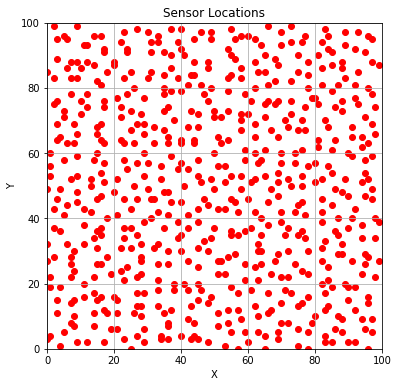

In [40]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the size of your domain
domain_size = (xsize, ysize)  # Example: xysizexxysize grid

n_srata = xysize    #  5
n_sensors = n_srata * n_srata

# Define the number of strata in each dimension
strata_size = (n_srata, n_srata)  # Example: 10x10 strata

# Calculate the size of each stratum
stratum_size = (domain_size[0] // strata_size[0], domain_size[1] // strata_size[1])

# Generate random sensor locations within each stratum
sensor_indices = np.array([
    (np.random.randint(i * stratum_size[0], (i + 1) * stratum_size[0]),
     np.random.randint(j * stratum_size[1], (j + 1) * stratum_size[1]))
    for i in range(strata_size[0])
    for j in range(strata_size[1])
])

# Plot the domain
plt.figure(figsize=(6, 6))
plt.xlim(0, domain_size[0])
plt.ylim(0, domain_size[1])

print(sensor_indices)

# Plot the sensor locations
plt.scatter(sensor_indices[:, 0], sensor_indices[:, 1], color='red')

plt.title('Sensor Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [41]:
# Convert sensor_indices to a PyTorch tensor
sensor_indices = torch.tensor(sensor_indices)

# Separate the x and y coordinates
x_coords = sensor_indices[:, 0]
y_coords = sensor_indices[:, 1]

# Use broadcasting to create a grid of indices
x_coords = x_coords[None, :, None]
y_coords = y_coords[None, :, None]

# Index the output and observation tensors at the sensor locations
# output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
# obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

# Now, output_at_sensors and obs_at_sensors should have the shape (302, 25)
# print(output_at_sensors.shape)
# print(obs_at_sensors.shape)

In [42]:
def plot_c_values(c_show, timesteps, n):
    """
    Function to plot the c values.

    Parameters:
    c_show (tensor): The tensor to be plotted.
    timesteps (int): The current timestep.
    n (int): The current epoch.
    """
    # Create the figure and axes
    fig, ax = plt.subplots()

    # Clear the previous image from the plot
    ax.clear()

    # Draw the new image
    im = ax.imshow(c_show.cpu().detach().numpy(), cmap='viridis')

    # Add a colorbar
    fig.colorbar(im, ax=ax)

    # Set the title
    ax.set_title('C Values - Optimised ts{}, es{}'.format(timesteps, n))

    # Redraw the plot
    plt.draw()
    plt.pause(0.001)  # Pause for a short period to allow the plot to update

    plt.show()

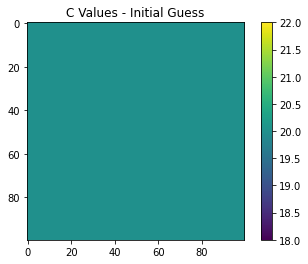

epochs: 0


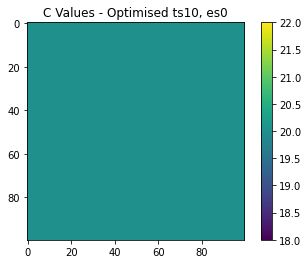

In [43]:
mse_loss = nn.MSELoss()

number_rows = 80   #40
number_cols = 80   #40
number_all = number_rows * number_cols

# C guess
C_guess_value = 20
# c_forward11 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_forward11 = create_c_field_likereal(C_guess_value, requires_grad=False).detach().requires_grad_(False)

# c_show = create_checkerboard(c_forward11, xysize, xysize, number_rows, number_cols)
c_show = create_c_field_likereal(C_guess_value, requires_grad=False)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y)

# Start a new run
# run = wandb.init(project="wave eqn - checkerboard", name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Initialize c_forward11 in the unconstrained space
c_forward11_unconstrained = torch.log(c_forward11).detach().requires_grad_(True)

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward11_unconstrained], lr)
c_values = [c_forward11.tolist()]

losses = []
epochs = 1

####################################################################################
####################################################################################
####################################################################################
####################################################################################
# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xsize, ysize, filter_weight)

for n in range(epochs):
    if n % 10 == 0:  # Print every 100 epochs
        print('epochs:', n)
        c_show = c_forward11

        
        # # Clear the previous image from the plot
        # # ax.clear()
        # # Draw the new image
        # plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        # # Add a colorbar
        # fig.colorbar(im, ax=ax)
        # # Set the title
        # plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, n))
        # # Redraw the plot
        # # plt.draw()
        # # plt.pause(0.001)  # Pause for a short period to allow the plot to update
        # plt.show()

        plot_c_values(c_show, timesteps, n)

    optimizer.zero_grad()

    # Apply the exponential function to c_forward11_unconstrained to get c_forward11
    c_forward11 = torch.exp(c_forward11_unconstrained)

    
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = create_checkerboard(c_forward11, xysize, xysize, number_rows, number_cols)
    c = c_forward11

    ########################################
    # total_loss = 0
    # for t in range(timesteps):
    #     output = model(input1, input2, c, sigma2)
    #     output_list.append(output[:,1:, :, :])
    #     input1 = output[:,1:, :, :]
    #     input2 = output[:,0:1, :, :]

    #     # Compute the loss for this timestep and add it to the total loss
    #     total_loss += mse_loss(output[:,1:, :, :].flatten(), Obs_sensor_3d_array[t+2,:].flatten())

    # # After the loop, total_loss is the sum of the losses from each timestep
    # loss = total_loss / timesteps

    # # Manually compute gradients
    # grads = torch.autograd.grad(loss, c_forward11_unconstrained, retain_graph=True)
    # # # Print the gradients
    # # print("Gradients:", grads)
    # c_forward11_unconstrained.grad = grads[0]


    ########################################
    # calculate grad each timestep
    # Initialize total gradient to 0
    # total_loss = 0
    # total_grad = 0
    # for t in range(timesteps):
    #     output = model(input1, input2, c, sigma2)
    #     output_list.append(output[:,1:, :, :])
    #     input1 = output[:,1:, :, :]
    #     input2 = output[:,0:1, :, :]
    #     # total_loss += mse_loss(output[:,1:, 10:-10, 10:-10].flatten(), Obs_sensor_3d_array[t+2,10:-10,10:-10].flatten())
    #     # # Compute the loss for this timestep
    #     # loss_t = mse_loss(output[:,1:, 10:-10, 10:-10].flatten(), Obs_sensor_3d_array[t+2, 10:-10, 10:-10].flatten())

    #     total_loss += mse_loss(output[:,1:, :,:].flatten(), Obs_sensor_3d_array[t+2,:,:].flatten())
    #     # Compute the loss for this timestep
    #     loss_t = mse_loss(output[:,1:, :,:].flatten(), Obs_sensor_3d_array[t+2, :,:].flatten())


    #     # Compute the gradient for this timestep
    #     grad_t = torch.autograd.grad(loss_t, c_forward11_unconstrained, retain_graph=True)[0]
    #     # Add the gradient for this timestep to the total gradient
    #     total_grad += grad_t
    # # After the loop, total_grad is the sum of the gradients from each timestep
    # c_forward11_unconstrained.grad = total_grad  / timesteps
    # loss = total_loss
    # losses.append(loss.item())
    ########################################


    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,-1:, :, :])
        input1 = output[:,-1:, :, :]
        input2 = output[:,-2:-1, :, :]

    # output_tensor = torch.cat(output_list, dim=1).squeeze(0)
    output_tensor = torch.cat(output_list, dim=1)
    # output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    # obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    output_tensor = output_tensor.squeeze(0)

#     s = mse_loss(output_tensor[-1].flatten(), Obs_sensor_3d_array[-1].flatten())

#     # loss = mse_loss(output_tensor.flatten(), Obs_sensor_3d_array.flatten())

#     # loss.backward(retain_graph=True)
#     # losses.append(loss.item())

#     ########################################
#     # ########################################


#     # for _ in range(timesteps):
#     #     output = model(input1, input2, c, sigma2)
#     #     output_list.append(output[:,-1:, :, :])
#     #     input1 = output[:,-1:, :, :]
#     #     input2 = output[:,-2:-1, :, :]

#     # # output_tensor = torch.cat(output_list, dim=1).squeeze(0)
#     # output_tensor = torch.cat(output_list, dim=1)
#     # # output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
#     # # obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

#     # loss = mse_loss(output_tensor.flatten(), Obs_sensor_3d_array.flatten())

#     # loss.backward(retain_graph=True)
#     # losses.append(loss.item())

#     # ########################################
#     # optimize C
#     optimizer.step()
#     c_values.append(c_forward11.tolist())

#     # Log the loss and c_value to wandb
#     # log_dict = {"loss": loss.item()}
#     # log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward11.tolist())})
#     # wandb.log(log_dict)

# plt.figure()
# plt.plot(losses)
# plt.title('Loss over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

# plt.figure()
# plt.plot(np.log(losses))  # Take the natural logarithm of the losses
# plt.title('Log Loss over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Log Loss')
# plt.show()

In [44]:
print(output_tensor.shape)
print(Obs_sensor_3d_array.shape)

torch.Size([12, 100, 100])
torch.Size([12, 100, 100])


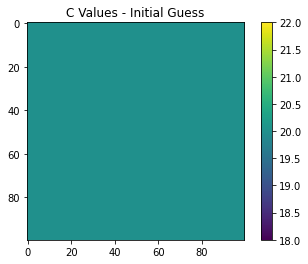

In [87]:
# C guess
C_guess_value = 20
# c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_forward1 = create_c_field_likereal(C_guess_value, requires_grad=False).detach().requires_grad_(True)

# c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
c_show = create_c_field_likereal(C_guess_value, requires_grad=True)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

# name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y)

# Start a new run
# run = wandb.init(project="wave eqn - checkerboard", name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Initialize c_forward1 in the unconstrained space
c_forward1_unconstrained = torch.log(c_forward1).detach().requires_grad_(True)

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1_unconstrained], lr)
c_values = [c_forward1.tolist()]

losses = []


optimizer.zero_grad()

# Apply the exponential function to c_forward1_unconstrained to get c_forward1
c_forward1 = torch.exp(c_forward1_unconstrained)


# Forward pass through the model
# output_list = [status_t0_tensor, status_t1_tensor]
input1 = status_t1_tensor*100000
input2 = status_t0_tensor*100000

# c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
c = c_forward1

c.requires_grad_(True)


model1 = AI4WaveNeuralNetwork_One_Skipping_New(xsize, ysize, filter_weight)

output = model1(input1, input2, c*1.5, sigma2)

In [88]:
print(output.grad)
print(output.shape)

None
torch.Size([1, 4, 100, 100])


In [89]:
print(c.grad)
print(c_forward1.grad)
print(c_forward1_unconstrained.grad)

None
None
None


In [90]:
# loss = mse_loss(output[0][-3].flatten(), Obs_sensor_3d_array[-3].flatten())
loss = mse_loss(output[0][-3:].flatten(), Obs_sensor_3d_array[-3:].flatten())
print(loss)

tensor(2321755.7500, device='cuda:0', grad_fn=<MseLossBackward0>)


In [91]:
loss.backward(retain_graph=True)

In [92]:
print(c.grad)
print(c_forward1.grad)
print(c_forward1_unconstrained.grad)

None
None
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [93]:
print(c_forward1_unconstrained.grad)
print(c_forward1_unconstrained.grad.sum().sum())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor(1299700.2500, device='cuda:0')


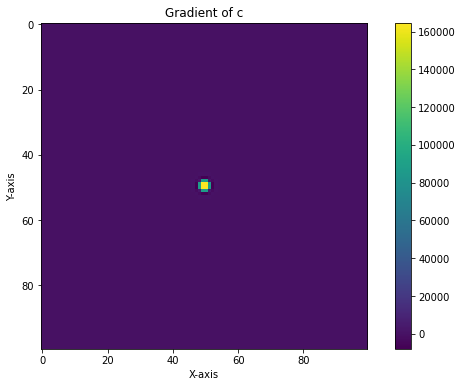

In [95]:
# Ensure c.grad is not None
if c_forward1_unconstrained.grad is not None:
    # Detach c.grad from the computation graph, convert to numpy for plotting
    grad_array = c_forward1_unconstrained.grad.detach().cpu().numpy()
    
    # Plotting
    plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
    plt.imshow(grad_array, cmap='viridis')  # Or any other colormap
    plt.colorbar()  # To show the gradient magnitude on the side
    plt.title('Gradient of c')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
else:
    print("c.grad is None. Ensure backward() has been called and c requires gradients.")

In [65]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values_unconstrained': c_forward1_unconstrained})

dot.render(filename='graph_smallmodel_c_forward1_unconstrained_26064', format='pdf')

'graph_smallmodel_c_forward1_unconstrained_26064.pdf'

epochs: 0


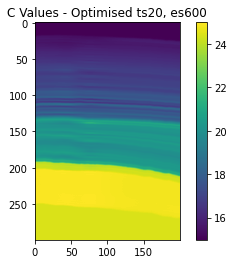

epochs: 10


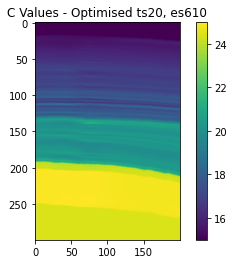

epochs: 20


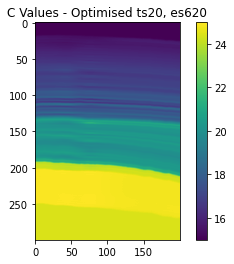

epochs: 30


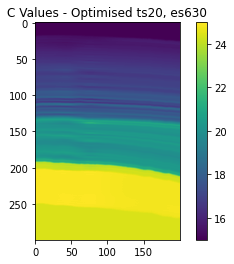

epochs: 40


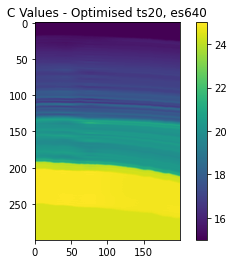

epochs: 50


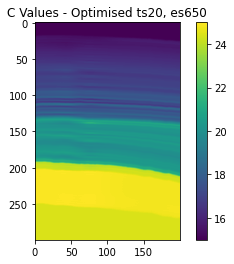

epochs: 60


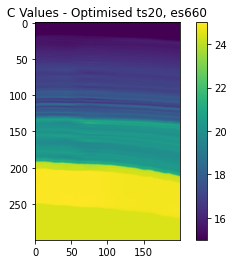

epochs: 70


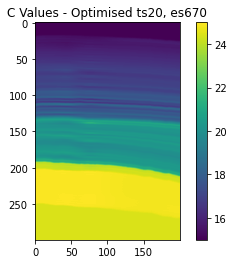

epochs: 80


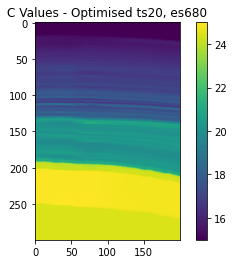

epochs: 90


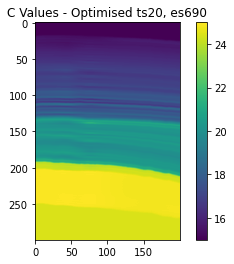

epochs: 100


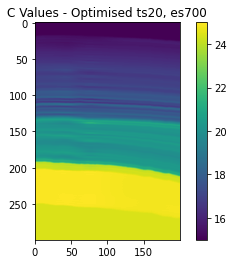

epochs: 110


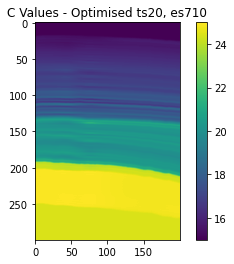

epochs: 120


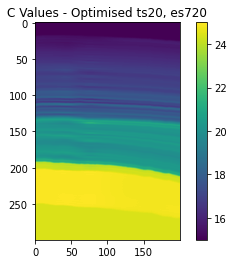

epochs: 130


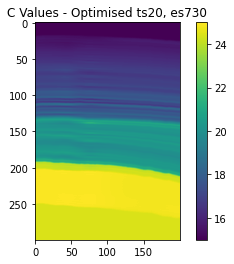

epochs: 140


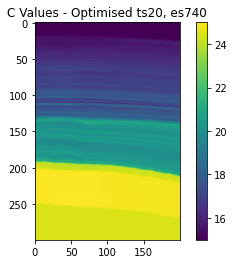

epochs: 150


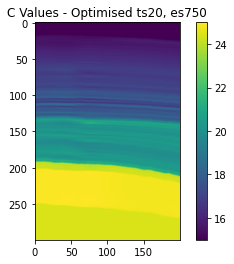

epochs: 160


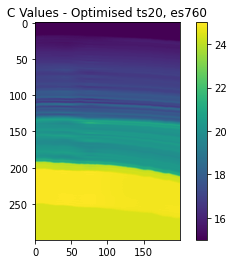

epochs: 170


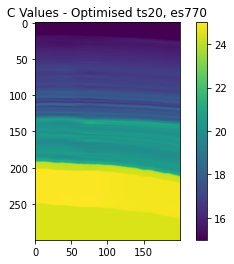

epochs: 180


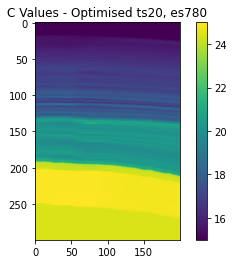

epochs: 190


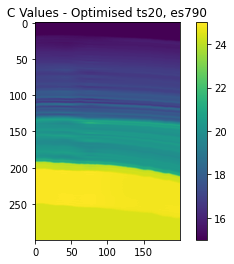

epochs: 200


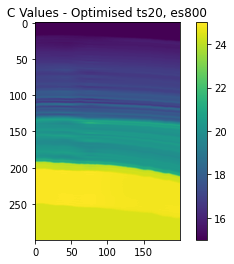

epochs: 210


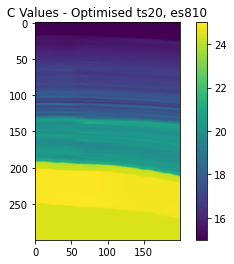

epochs: 220


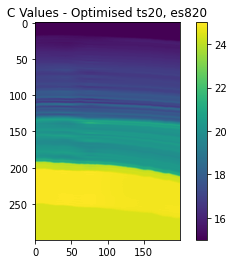

epochs: 230


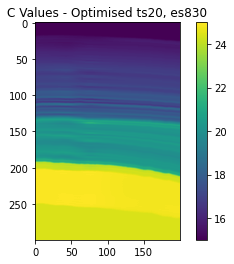

epochs: 240


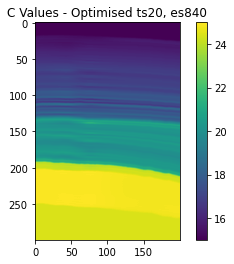

epochs: 250


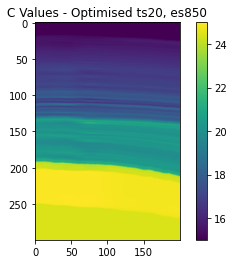

epochs: 260


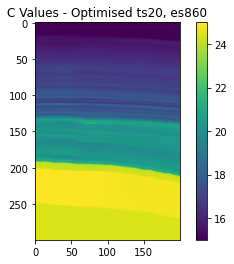

epochs: 270


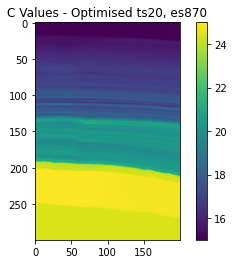

epochs: 280


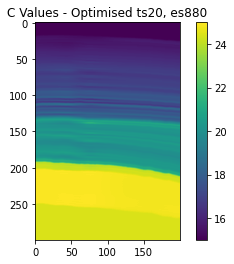

epochs: 290


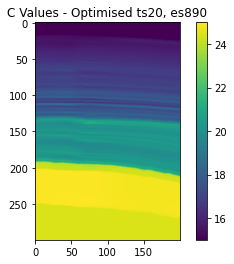

epochs: 300


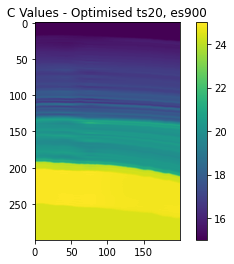

epochs: 310


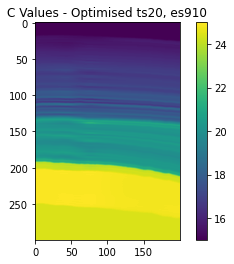

epochs: 320


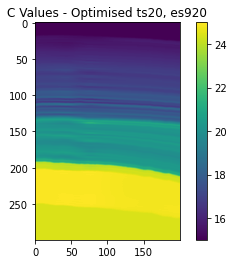

epochs: 330


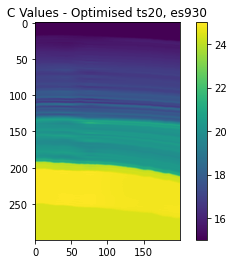

epochs: 340


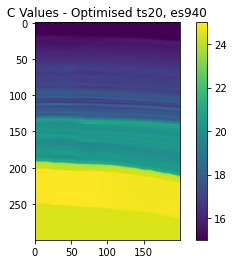

epochs: 350


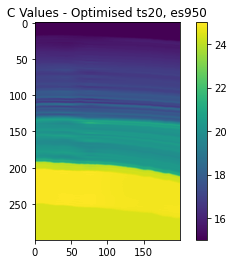

epochs: 360


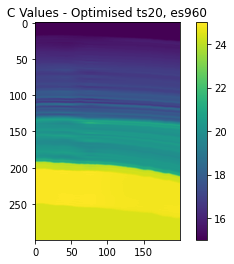

epochs: 370


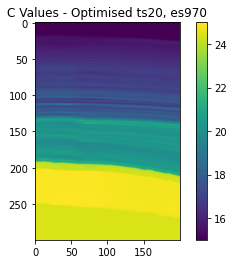

epochs: 380


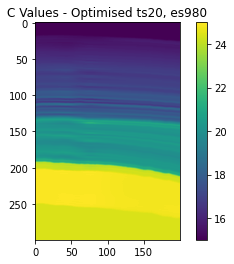

epochs: 390


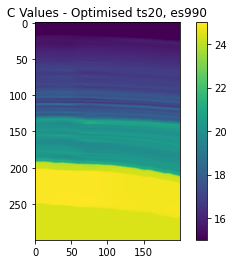

epochs: 400


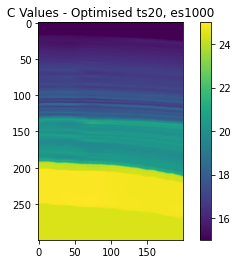

epochs: 410


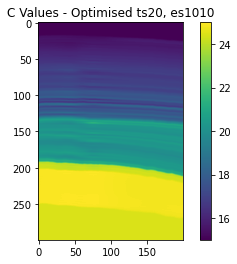

epochs: 420


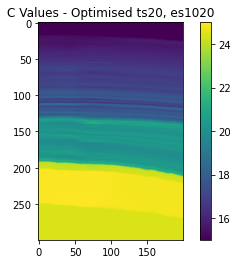

epochs: 430


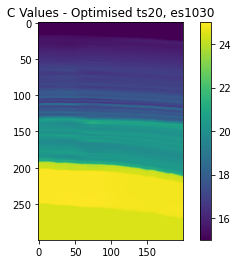

epochs: 440


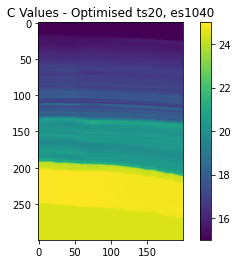

epochs: 450


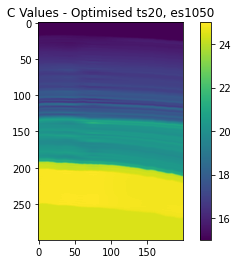

epochs: 460


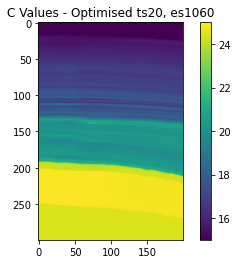

epochs: 470


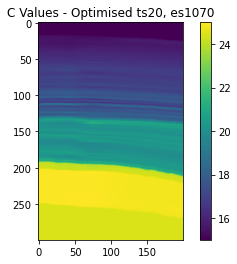

epochs: 480


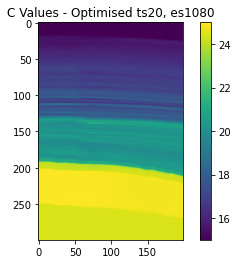

epochs: 490


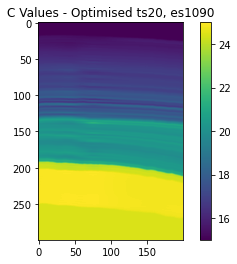

epochs: 500


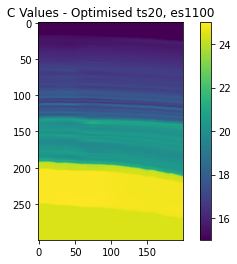

epochs: 510


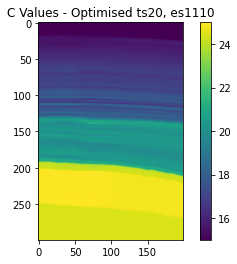

epochs: 520


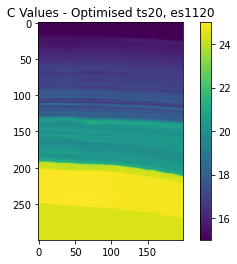

epochs: 530


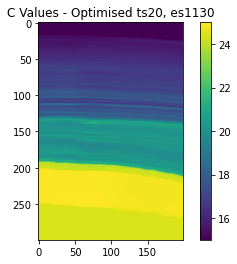

epochs: 540


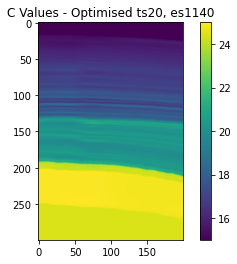

epochs: 550


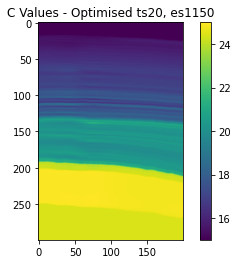

epochs: 560


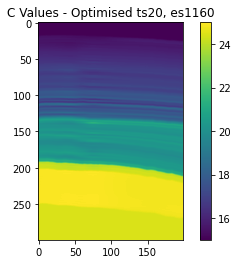

epochs: 570


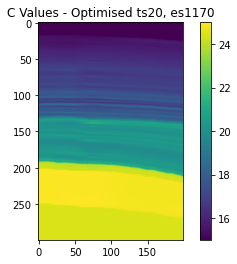

epochs: 580


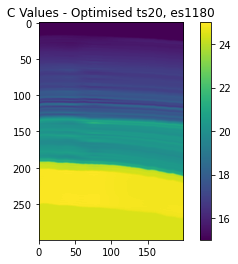

epochs: 590


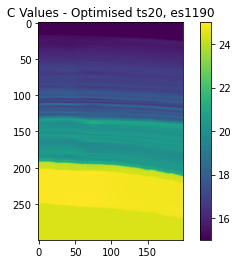

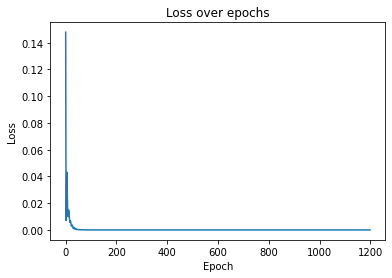

In [45]:
for n in range(epochs):
    if n % 10 == 0:  # Print every 100 epochs
        print('epochs:', n)
        c_show = c_forward1

        
        # # Clear the previous image from the plot
        # # ax.clear()
        # # Draw the new image
        # plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        # # Add a colorbar
        # fig.colorbar(im, ax=ax)
        # # Set the title
        # plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, n))
        # # Redraw the plot
        # # plt.draw()
        # # plt.pause(0.001)  # Pause for a short period to allow the plot to update
        # plt.show()

        plot_c_values(c_show, timesteps, n+epochs)

    optimizer.zero_grad()

    # Apply the exponential function to c_forward1_unconstrained to get c_forward1
    c_forward1 = torch.exp(c_forward1_unconstrained)

    
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
    c = c_forward1

    ########################################
    # total_loss = 0
    # for t in range(timesteps):
    #     output = model(input1, input2, c, sigma2)
    #     output_list.append(output[:,1:, :, :])
    #     input1 = output[:,1:, :, :]
    #     input2 = output[:,0:1, :, :]

    #     # Compute the loss for this timestep and add it to the total loss
    #     total_loss += mse_loss(output[:,1:, :, :].flatten(), Obs_sensor_3d_array[t+2,:].flatten())

    # # After the loop, total_loss is the sum of the losses from each timestep
    # loss = total_loss / timesteps

    # # Manually compute gradients
    # grads = torch.autograd.grad(loss, c_forward1_unconstrained, retain_graph=True)
    # # # Print the gradients
    # # print("Gradients:", grads)
    # c_forward1_unconstrained.grad = grads[0]


    ########################################
    # calculate grad each timestep
    # Initialize total gradient to 0
    total_loss = 0
    total_grad = 0
    for t in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]
        # total_loss += mse_loss(output[:,1:, 10:-10, 10:-10].flatten(), Obs_sensor_3d_array[t+2,10:-10,10:-10].flatten())
        # # Compute the loss for this timestep
        # loss_t = mse_loss(output[:,1:, 10:-10, 10:-10].flatten(), Obs_sensor_3d_array[t+2, 10:-10, 10:-10].flatten())

        total_loss += mse_loss(output[:,1:, :,:].flatten(), Obs_sensor_3d_array[t+2,:,:].flatten())
        # Compute the loss for this timestep
        loss_t = mse_loss(output[:,1:, :,:].flatten(), Obs_sensor_3d_array[t+2, :,:].flatten())


        # Compute the gradient for this timestep
        grad_t = torch.autograd.grad(loss_t, c_forward1_unconstrained, retain_graph=True)[0]
        # Add the gradient for this timestep to the total gradient
        total_grad += grad_t
    # After the loop, total_grad is the sum of the gradients from each timestep
    c_forward1_unconstrained.grad = total_grad  / timesteps
    loss = total_loss
    losses.append(loss.item())
    ########################################

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    # log_dict = {"loss": loss.item()}
    # log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    # wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

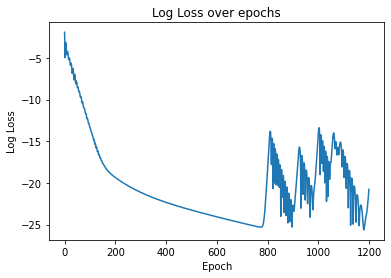

In [46]:
plt.figure()
plt.plot(np.log(losses))  # Take the natural logarithm of the losses
plt.title('Log Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.show()

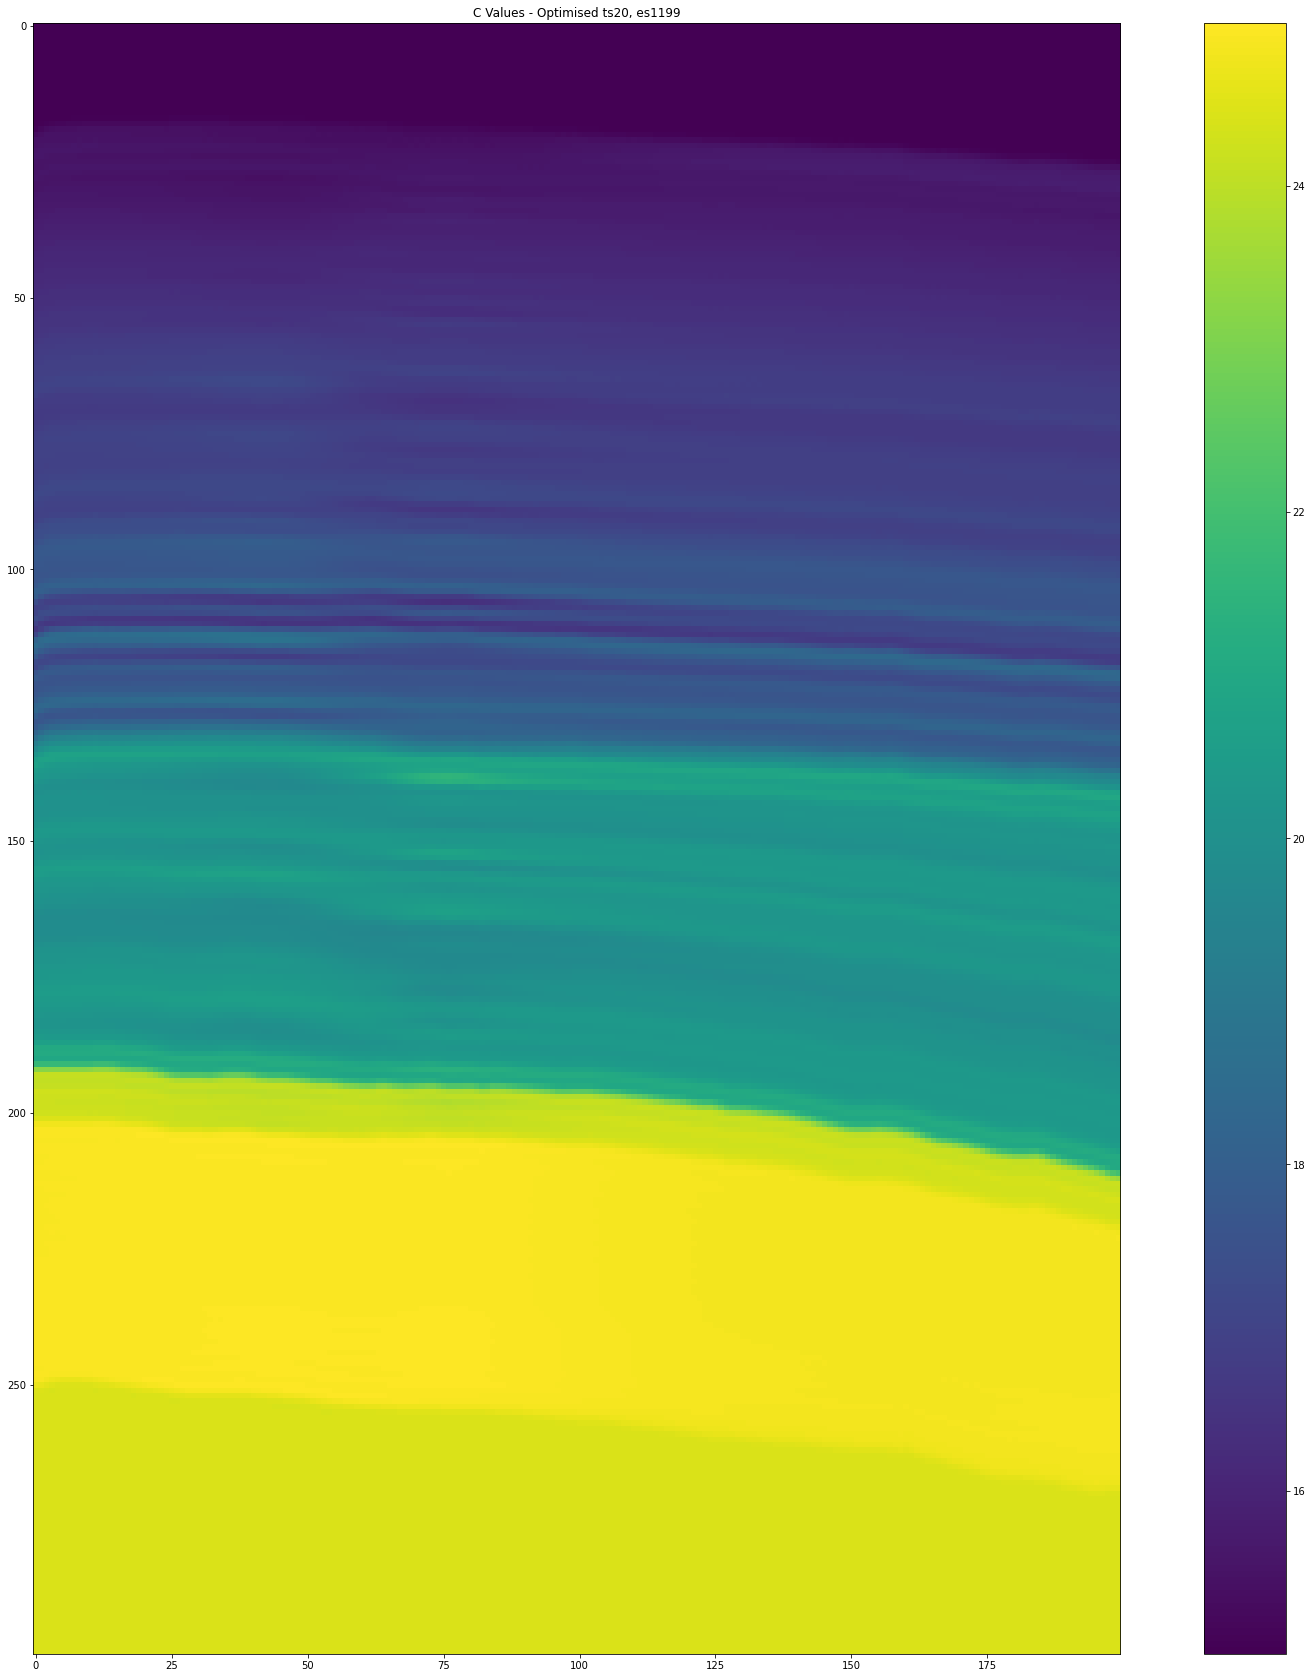

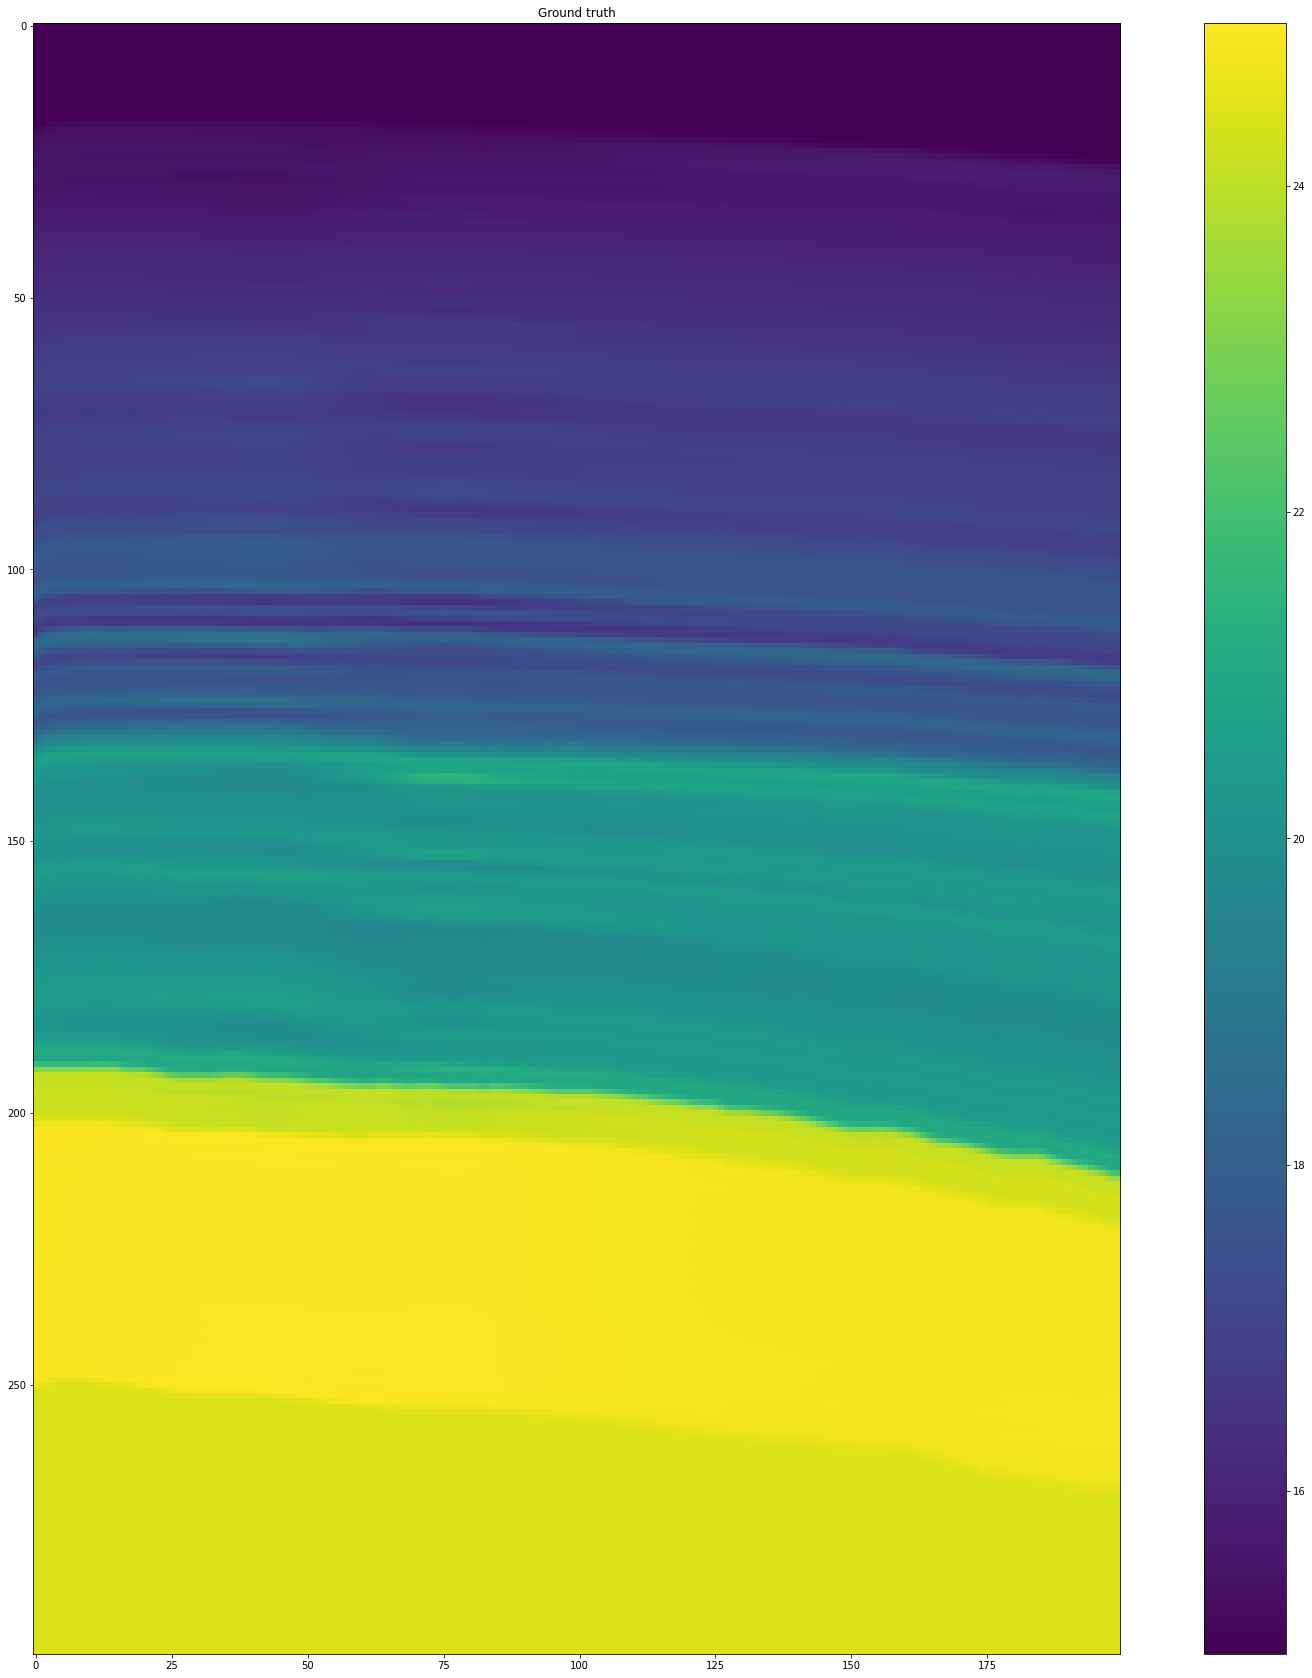

In [48]:
## sources 20*20  ts 20 epochs 1200  domain 300*200

plt.figure(figsize=(30, 30))
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, n+epochs))
plt.show()

plt.figure(figsize=(30, 30))
plt.imshow(scaled_data)
plt.title('Ground truth')
plt.colorbar()

#### Visualise computational graph

In [ ]:
mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*number_rows*number_cols, dtype=torch.float32, device=device, requires_grad=True)

# C guess
C_guess_value = 20
c_forward1 = create_c_field_likereal(C_guess_value, requires_grad=False).detach().requires_grad_(True)
c_forward1_unconstrained = torch.log(c_forward1).detach().requires_grad_(True)


# lr = 0.1
lr = 0.1

# Use Adam optimizer
# optimizer = torch.optim.Adam([c_forward1], lr)
optimizer = torch.optim.Adam([c_forward1_unconstrained], lr)
# c_values = [c_forward1.tolist()]

losses = []

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(1):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
    
    c_forward1 = torch.exp(c_forward1_unconstrained)
    # c = c_forward1

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    print(loss.item())

epochs: 0
5.4717977036489174e-05


In [ ]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})


dot.render(filename='graph_smallmodel_2timesss', format='pdf')
# dot.render(filename='graph_smallmodel_entiredomain_2times', format='pdf')

'graph_smallmodel_2timesss.pdf'

In [ ]:
# Visualize the computational graph
dot = make_dot(loss, params={'c_values_unconstrained': c_forward1_unconstrained})

dot.render(filename='graph_smallmodel_entiredomain_2times_c_forward1_unconstrained', format='pdf')

'graph_smallmodel_entiredomain_2times_c_forward1_unconstrained.pdf'